# Simulation 1
## From the paper "Distribution-free inference with hierarchical data"
### by Yonghoon Lee, Rina Foygel Barber, and Rebecca Willett
https://arxiv.org/abs/2306.06342


The script reproduces the simulation in Section 2.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import trunc
import statistics
from itertools import combinations
from scipy.stats import norm
import random

In [2]:
np.random.seed(1234)
random.seed(1234)

#### Functions

In [3]:
#functions
def f_mu_quadratic(x):
  mu = 1+x+0.1*(x**2)
  return mu

def score_residual(y,muhat):
  s = np.abs(y-muhat)
  return s

def quantile(probs,values,level):
  ind = [np.sum(np.multiply(probs,(values<=v))) >= 1-level for v in values]
  q = np.min(values[np.where(np.array(ind) == True)[0]])
  return q

def normal_coverage(CI,mu,sigma):
  return(norm.cdf((CI[1]-mu)/sigma)-norm.cdf((CI[0]-mu)/sigma))

In [4]:
def HCP(X,Y,group_sizes,alpha,score,muhat):
  K = np.shape(X)[0]

  score_tilde = {}
  for i in range(K):
    score_tilde[i] = score(Y[i],muhat[i])

  values = []
  prob = []

  for i in range(K):
    values = values+(score_tilde[i]).tolist()
    prob = prob+[1/((K+1)*group_sizes[i])]*group_sizes[i]

  values = np.array(values+[np.inf] )
  prob = np.array(prob+[1/(K+1)])

  q = quantile(prob,values,alpha)

  return q

def double_conformal(Y,alpha):
  K = len(Y)
  N = np.shape(Y[0])[0]
  r_0 = np.max([1,math.floor((N+1)*alpha/2)])-1
  s_0 = np.min([math.ceil((N+1)*(1-alpha/2)),N])-1
  l_vec = np.zeros(K)
  u_vec = np.zeros(K)
  for i in range(K):
    y_sort = np.sort(Y[i])
    l_vec[i] = y_sort[r_0]
    u_vec[i] = y_sort[s_0]

  r = np.max([1,math.floor((K+1)*alpha/4)])-1
  s = np.min([math.ceil((K+1)*(1-alpha/2)),K])-1

  l = (np.sort(l_vec))[r]
  u = (np.sort(u_vec))[s]

  return([l,u])

def pooling_cdfs(X,Y,group_sizes,alpha,score,muhat):
  K = np.shape(X)[0]

  score_tilde = {}
  for i in range(K):
    score_tilde[i] = score(Y[i],muhat[i])

  values = []
  prob = []

  for i in range(K):
    values = values+(score_tilde[i]).tolist()
    prob = prob+[1/(K*group_sizes[i])]*group_sizes[i]

  values = np.array(values)
  prob = np.array(prob)

  q = quantile(prob,values,alpha)

  return q


#subsampling once
def subsampling_once(Y,alpha):
  K = len(Y)
  Y_subsample = np.array([np.random.choice(Y[i],1)[0] for i in range(K)])
  Y_subsample_sort = np.sort(Y_subsample)
  r = int(np.floor((K+1)*alpha/2)-1)
  s = int(np.ceil((K+1)*(1-alpha/2))-1)
  return(np.array([Y_subsample_sort[r],Y_subsample_sort[s]]))


#### First split of data

In [5]:
K_0=10
K_1=10
N=2
Sigma = np.ones((N,N)) + np.diag(np.ones(N))

In [6]:
X0 = np.random.multivariate_normal(np.zeros(N),Sigma,K_0)
mu0 = f_mu_quadratic(X0)
Y0 = [np.random.multivariate_normal(mu0[i],Sigma,1)[0] for i in range(K_0)]
X0_vec = np.concatenate(X0)
Y0_vec = np.concatenate(Y0)
X0_mat = np.column_stack((np.ones(K_0*N),X0_vec))
beta = np.linalg.solve(np.matmul(X0_mat.transpose(),X0_mat),np.matmul(X0_mat.transpose(),Y0_vec))

#### run HCP / double conformal / Pooling CDFs / Subsampling once

In [7]:
score = score_residual

n_trial = 500
M=1000
alpha=0.2

coverage_HCP = np.zeros((n_trial,M))
coverage_double_conformal = np.zeros((n_trial,M))
coverage_pooling_cdfs = np.zeros((n_trial,M))
coverage_subsampling_once = np.zeros((n_trial,M))
width_HCP = np.zeros((n_trial,M))
width_double_conformal = np.zeros((n_trial,M))
width_pooling_cdfs = np.zeros((n_trial,M))
width_subsampling_once = np.zeros((n_trial,M))

X_test = np.random.normal(0,np.sqrt(2),M)
mu_test = f_mu_quadratic(X_test)
muhat_test = beta[0]+beta[1]*X_test

for t in range(n_trial):
  #print(t)

  X1 = np.random.multivariate_normal(np.zeros(N),Sigma,K_1)
  mu1 = f_mu_quadratic(X1)
  Y1 = [np.random.multivariate_normal(mu1[i],Sigma,1)[0] for i in range(K_1)]
  N1 = [N]*K_1

  residuals = {}
  muhat_train = beta[0]+beta[1]*X1

  for i in range(K_1):
   residuals[i] = Y1[i]-muhat_train[i,]

  quantile_HCP = HCP(X1,Y1,N1,alpha,score,muhat_train)
  quantile_pooling_cdfs = pooling_cdfs(X1,Y1,N1,alpha,score,muhat_train)
  CI_score_double_conformal = np.array(double_conformal(residuals,alpha))
  CI_score_subsampling_once = subsampling_once(residuals,alpha)

  for j in range(M):
    muhat_new = muhat_test[j]
    mu_new = mu_test[j]
    sigma_new = np.sqrt(2)

    CI_split_marginal = [muhat_new - quantile_HCP,muhat_new + quantile_HCP]
    CI_double_conformal = CI_score_double_conformal+muhat_new
    CI_pooling_cdfs = [muhat_new - quantile_pooling_cdfs,muhat_new +quantile_pooling_cdfs]
    CI_subsampling_once = CI_score_subsampling_once+muhat_new

    coverage_HCP[t,j] = normal_coverage(CI_split_marginal,mu_new,sigma_new)
    coverage_double_conformal[t,j] = normal_coverage(CI_double_conformal,mu_new,sigma_new)
    coverage_pooling_cdfs[t,j] = normal_coverage(CI_pooling_cdfs,mu_new,sigma_new)
    coverage_subsampling_once[t,j] = normal_coverage(CI_subsampling_once,mu_new,sigma_new)

    width_HCP[t,j] = CI_split_marginal[1] - CI_split_marginal[0]
    width_double_conformal[t,j] = CI_double_conformal[1] - CI_double_conformal[0]
    width_pooling_cdfs[t,j] = CI_pooling_cdfs[1] - CI_pooling_cdfs[0]
    width_subsampling_once[t,j] = CI_subsampling_once[1] - CI_subsampling_once[0]


In [8]:
HCP_coverage = np.mean(coverage_HCP,axis=1)
pooling_coverage = np.mean(coverage_pooling_cdfs,axis=1)
double_coverage = np.mean(coverage_double_conformal,axis=1)
subsampling_coverage = np.mean(coverage_subsampling_once,axis=1)

HCP_width = np.mean(width_HCP,axis=1)
pooling_width = np.mean(width_pooling_cdfs,axis=1)
double_width = np.mean(width_double_conformal,axis=1)
subsampling_width = np.mean(width_subsampling_once,axis=1)

In [9]:
simulation_coverage = np.column_stack((HCP_coverage, pooling_coverage, double_coverage,subsampling_coverage))
simulation_width = np.column_stack((HCP_width,pooling_width, double_width, subsampling_width))

#### Table / Plot

In [10]:
marginal_coverage = {"split conformal":np.mean(simulation_coverage[:,0]),"pooling cdfs":np.mean(simulation_coverage[:,1]),"double conformal":np.mean(simulation_coverage[:,2]),"subsampling once":np.mean(simulation_coverage[:,3])}
m = np.shape(simulation_coverage[:,0])[0]
marginal_coverage_se = {"split conformal":np.std(simulation_coverage[:,0])/np.sqrt(m),"pooling cdfs":np.std(simulation_coverage[:,1])/np.sqrt(m),"double conformal":np.std(simulation_coverage[:,2])/np.sqrt(m),"subsampling once":np.std(simulation_coverage[:,3])/np.sqrt(m)}

marginal_width = {"split conformal":np.mean(simulation_width[:,0]),"pooling cdfs":np.mean(simulation_width[:,1]),"double conformal":np.mean(simulation_width[:,2]),"subsampling once":np.mean(simulation_width[:,3])}
m = np.shape(simulation_width[:,0])[0]
marginal_width_se = {"split conformal":np.std(simulation_width[:,0])/np.sqrt(m),"pooling cdfs":np.std(simulation_width[:,1])/np.sqrt(m),"double conformal":np.std(simulation_width[:,2])/np.sqrt(m),"subsampling once":np.std(simulation_width[:,3])/np.sqrt(m)}


In [11]:
table_coverage = np.vstack((
np.fromiter(marginal_coverage.values(),dtype='float'),
np.fromiter(marginal_coverage_se.values(),dtype='float'),
))

table_width = np.vstack((
np.fromiter(marginal_width.values(),dtype='float'),
np.fromiter(marginal_width_se.values(),dtype='float')
))

In [12]:
np.set_printoptions(precision=4,suppress=True)
print(np.hstack((np.transpose(table_coverage),np.transpose(table_width))))

[[0.8553 0.0034 5.4151 0.0488]
 [0.7658 0.0042 4.3578 0.0429]
 [0.894  0.0031 5.7489 0.0527]
 [0.8177 0.0048 4.8216 0.0564]]


/tmp/ipykernel_11074/2264958343.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


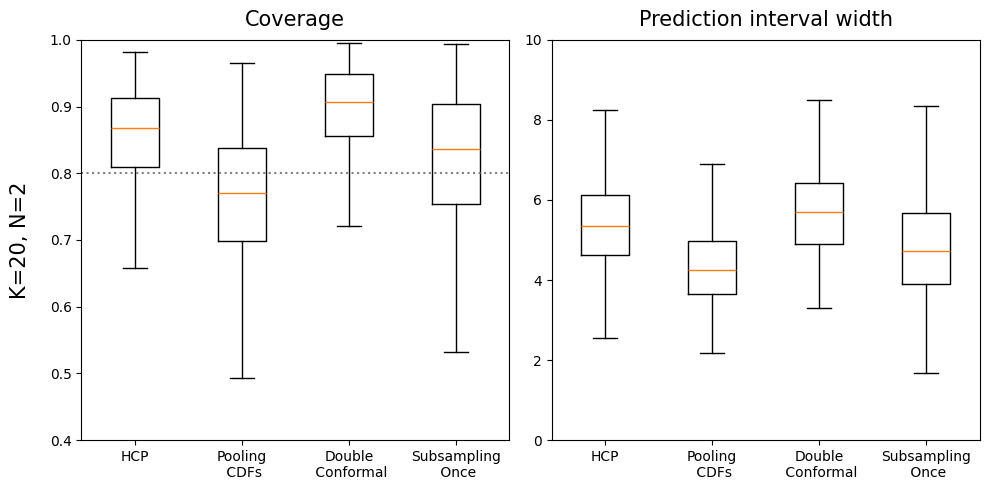

In [13]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
ax1.boxplot(simulation_coverage, showfliers=False)
ax1.set_xticklabels(['HCP','Pooling\n CDFs','Double\n Conformal','Subsampling\n Once'])
ax1.set_title('Coverage',fontsize=15,pad=10)
ax1.get_yaxis().set_label_coords(-0.12,0.5)
ax1.set_ylim([0.4,1])
ax1.set_ylabel("K=20, N=2",fontsize=15,labelpad=5)
ax1.axhline(y=0.8, color='grey', linestyle=':')
ax2.boxplot(simulation_width, showfliers=False)
ax2.set_xticklabels(['HCP','Pooling\n CDFs','Double\n Conformal','Subsampling\n Once'])
ax2.set_title('Prediction interval width',fontsize=15,pad=10)
ax2.set_ylim([0,10])

fig.show()